**Lab 7 : Node2Vec**
- Instuctor : Kijung Shin
- Teaching Assistants : Hyunju Lee(main), Deukryeol Yoon, Shinhwan Kang 
- 본 실습에서는 random walk 기반 network embedding 방법 중 하나인 node2vec 알고리즘을 사용하여 clustering, node classification과 같은 여러 downstream task들을 수행해본다.

* 학습 목표

> 1. node2vec library의 사용법을 익힌다.
2. node2vec embedding 벡터를 사용하여 여러 downstream tasks(clustering, node classification)를 수행하는 방법을 익힌다.




**Clustering with Node2Vec**


In [1]:
!pip install networkx
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.1-cp37-none-any.whl size=5734 sha256=988e251e877db9ec0f5597e0ef3105806ba627abb394bdae3fd321cc4620913a
  Stored in directory: /root/.cache/pip/wheels/b3/59/ea/22e964f74bb864c5423cf82027a4d69dd65bac0bbf95fd46f5
Successfully built node2vec


In [2]:
import networkx as nx
from node2vec import Node2Vec
from matplotlib import pyplot as plt

In [3]:
import os, sys 
from google.colab import drive 

### 해당 코드 실행 시 colab에서 실행중인 폴더의 /content/drive/My Drive가 구글 드라이브에 연결됨

drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
###################### Dataset Description ##########################
'''
    [Reference]
        title={The Network Data Repository with Interactive Graph Analytics and Visualization},
        author={Ryan A. Rossi and Nesreen K. Ahmed},
        booktitle={AAAI},
        url={http://networkrepository.com},
        year={2015}

'''
###### lesmis.mtx : <node 1> <node 2> <weight> ######################
###### weight : 레미제라블에 동시에 등장한 등장인물의 횟수 ##########
#####################################################################

'\n    [Reference]\n        title={The Network Data Repository with Interactive Graph Analytics and Visualization},\n        author={Ryan A. Rossi and Nesreen K. Ahmed},\n        booktitle={AAAI},\n        url={http://networkrepository.com},\n        year={2015}\n\n'

In [5]:
##### Weighted Graph Generation #####

weighted_edgelist=[]
with open('drive/MyDrive/data/lab/lab7/lesmis.mtx', 'r') as f:
    for line in f:
        l = line.strip().split()
        if l[0].isdigit() == False:
            continue
        weighted_edgelist.append((str(int(l[0])-1), str(int(l[1])-1), float(l[2])))


G = nx.Graph()
G.add_weighted_edges_from(weighted_edgelist)       

In [6]:
############################ Fill in Your Code ############################################
node2vec = Node2Vec(G, dimensions=16, walk_length=4, num_walks=200, workers=4) # graph,embedding 공간 dimension,최대 워크 거리,샘플 수, 스레드 갯수
model= node2vec.fit(window=2)# 얼마나 가까이 위치한 정점을 유사한것으로 볼까
##############################################################################################

In [7]:
print("#### Embedding Vector of Node 2 ####")
print(model.wv['2'])

#### Embedding Vector of Node 2 ####
[-0.07380738  0.62507224  0.18938778 -0.4683118  -0.2954783   0.3478548
 -0.7351034  -1.0035715   1.4829712  -1.3467369   0.28122205  0.62524915
 -0.10347127 -0.01408068 -0.00612468 -0.5950588 ]


In [8]:
##### Node 2와 가장 유사한 10개의 node를 출력 #####

print("#### Most Similar Nodes to Node 2")
model.wv.most_similar('2')  

#### Most Similar Nodes to Node 2


[('3', 0.9927242398262024),
 ('5', 0.9870062470436096),
 ('1', 0.9851337671279907),
 ('6', 0.984713077545166),
 ('4', 0.9841172695159912),
 ('8', 0.9806505441665649),
 ('7', 0.9787570834159851),
 ('9', 0.977963387966156),
 ('0', 0.9571969509124756),
 ('11', 0.6869795322418213)]

In [9]:
# 군집 분석 구간
from sklearn.cluster import KMeans
import numpy as np
from matplotlib import pyplot as plt

In [12]:
#### sklearn.cluster의 KMeans 알고리즘을 실행시키기 위해 node별 embedding 값을 array로 변환해준다 
#### 노드 번호에 해당하는 index에 embedding 값을 저장
vectors_array = np.zeros((len(G.nodes), 16))
for node in G.nodes:
    vectors_array[int(node)] = model.wv[node]

In [13]:
#### kmeans clustering 알고리즘 실행 ###

############### Fill in Your Code #############################
kmeans=KMeans(n_clusters=5, random_state=0).fit(vectors_array) # K-Means 정점의 군집(Cluster!= community) 탐색
################################################################

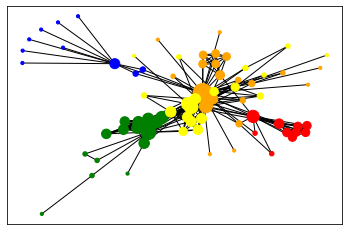

In [14]:
# 그래프 군집 분석 방법 
#1. G-N, Louvain 알고리즘 : 그래프를 위한 군집 분석 알고리즘
#2. Node2Vec  : node embedding 방법,임베딩 벡터로 바꾼뒤 이후 k-means 같은 clustering 방법 사용

#### 그래프 시각화 - 각 클러스터별로 다른 색깔을 갖도록 함 ####
pos = nx.spring_layout(G)
node_color=[]
node_degree = []
for node in G.nodes:
    node_degree.append(G.degree[node]*10)
    i = int(node)
    if kmeans.labels_[i] == 0:
        node_color.append('red')
    elif kmeans.labels_[i] == 1:
        node_color.append('yellow')
    elif kmeans.labels_[i] == 2:
        node_color.append('blue')
    elif kmeans.labels_[i] == 3:
        node_color.append('green')
    else:
        node_color.append('orange')

img = nx.draw_networkx_nodes(G, pos, node_color = node_color, node_size=node_degree)
nx.draw_networkx_edges(G, pos)
plt.show()

**Node Classification**

In [16]:
###################### Dataset Description ##########################
##### cora.content : <paper_id> <word_attributes> <class_name> #####
##### cora.cites : <ID of cited paper> <ID of citing paper> #########
#####################################################################

In [19]:
# Directed Graph Generation 
# 메모리 활용을 위해 node class는 숫자로 re-labelling하여 사용
# 사용할 파일 가져오기(논문)
node_class = dict()
edgelist = list()
class_num = 1
class_name_to_num = dict()
with open('drive/MyDrive/data/lab/lab7/cora.content', 'r') as f, open('drive/MyDrive/data/lab/lab7/cora.cites','r') as f2:
    for line in f:
        l = line.strip().split()
        class_name = l[-1]
        if class_name not in class_name_to_num:
            class_name_to_num[class_name] = class_num
            class_num += 1
        node_class[l[0]] = class_name_to_num[class_name]

    for line in f2:
        l = line.strip().split()
        edgelist.append((l[1],l[0]))


G = nx.DiGraph()
G.add_edges_from(edgelist)


In [20]:
import time

In [24]:
s= time.time()
##### Node Embedding #####
node2vec = Node2Vec(G, dimensions=16, walk_length=4, num_walks=200, workers=4)  
model = node2vec.fit(window=10, min_count=1, batch_words=4) 
print("runtime: ", time.time() - s)


runtime:  597.13583111763


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score


In [27]:
#### X : embedding of a node, y : class label of a node ####
# 학습데이터 평가데이터 분리
X = list()
y = list()
node_name_to_idx = dict()
for i, (v, class_) in enumerate(node_class.items()):
    node_name_to_idx[v] = i
    X.append(model.wv[v])
    y.append(class_)
X = np.array(X)
y = np.array(y)

#################### Fill in Your Code ################################
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True)
#######################################################################


In [28]:
#################### Fill in Your Code ################################
clf = MLPClassifier(max_iter=500).fit(X_train, y_train) # 다층퍼셉트론 학습
y_predict=clf.predict(X_test)

######################################################################

print("###### Result of prediction #####")
print("Accuracy : {0:05.2f}% ".format(accuracy_score(y_test, y_predict)*100))

###### Result of prediction #####
Accuracy : 76.96% 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [29]:
print("########## Comparison of Predicted and Test Results ######")
for i in range(len(y_test)//20):
    print("#########################################################")
    print("예측: ", y_predict[i*20:(i+1)*20])
    print("실제: ", y_test[i*20:(i+1)*20])

########## Comparison of Predicted and Test Results ######
#########################################################
예측:  [6 4 1 1 1 7 3 1 1 5 6 1 5 4 7 4 4 1 1 4]
실제:  [6 4 1 1 1 7 1 1 1 5 6 5 5 4 7 1 1 4 5 4]
#########################################################
예측:  [1 6 1 6 6 6 5 6 5 1 7 7 1 3 6 6 6 3 5 2]
실제:  [1 6 1 6 6 6 5 6 1 1 7 7 1 1 6 6 6 3 1 2]
#########################################################
예측:  [4 6 1 2 5 1 1 1 1 1 1 6 1 2 1 4 5 1 5 4]
실제:  [4 6 4 2 4 1 1 1 1 1 7 6 5 2 1 4 4 1 2 4]
#########################################################
예측:  [1 5 2 4 1 7 7 4 1 1 4 1 6 6 4 7 3 7 3 1]
실제:  [1 5 5 4 1 7 1 4 1 1 4 1 6 6 4 7 3 7 3 1]
#########################################################
예측:  [5 2 6 5 1 5 7 3 2 4 1 6 1 7 1 6 1 1 1 6]
실제:  [5 5 6 1 1 5 7 3 2 4 5 3 1 7 1 6 1 4 1 6]
#########################################################
예측:  [2 3 1 7 1 3 1 1 4 2 6 4 7 7 6 7 1 7 7 1]
실제:  [5 3 1 7 1 3 1 1 5 2 6 4 7 4 6 7 1 7 7 1]
#############################